## Preparación inicial Google Colab

Librerías necesarias. Reiniciar runtime tras instalación

In [ ]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

Acceso a datasets y repo en github

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Proyecto_inteligencia/alerce5b
! git pull

## Carga de datos desde el dataset alerceZTFv7.1

In [2]:
import numpy as np
import pandas as pd

survey_name = 'alerceZTFv7.1' # use this dataset
### load files
load_root_dir = f'./data/{survey_name}'
labels_df = pd.read_parquet(f'{load_root_dir}/labels_vs.parquet')
print(f'labels_df; columns={list(labels_df.columns)}; id={labels_df.index.name}')
detections_df = pd.read_parquet(f'{load_root_dir}/detections_vs.parquet')
print(f'detections_df; columns={list(detections_df.columns)}; id={detections_df.index.name}')

### print info
classes = sorted(set(labels_df['classALeRCE'].values))
print(f'classes={classes}')

labels_df; columns=['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec']; id=oid
detections_df; columns=['fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr']; id=oid
classes=['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL']


In [3]:
detections_df

,fid,mjd,magpsf_corr,sigmapsf_corr
oid,,,,
ZTF17aaafyya,1,58791.283368,15.262989,0.004987
ZTF17aaafyya,1,59081.470544,15.281165,0.007919
ZTF17aaafyya,1,59067.403970,15.245437,0.000493
ZTF17aaafyya,1,58793.249965,15.205705,0.010043
ZTF17aaafyya,1,58793.239028,15.228786,0.009911
...,...,...,...,...
ZTF20abceckn,1,58976.471597,17.589780,0.036465
ZTF20abceckn,2,58998.320336,17.600946,0.013244
ZTF20abceckn,2,58986.296597,17.655712,0.017770


Número de objetos astronómicos en las detecciones

In [4]:
detections_df.index.nunique()

82237

Cambio de nombre de las columnas de las detecciones para posterior extracción de features

In [5]:
detections_df = detections_df.rename(columns={'fid' : 'band', 'mjd': 'time', 'magpsf_corr': 'magnitude', 'sigmapsf_corr': 'error'})
detections_df

,band,time,magnitude,error
oid,,,,
ZTF17aaafyya,1,58791.283368,15.262989,0.004987
ZTF17aaafyya,1,59081.470544,15.281165,0.007919
ZTF17aaafyya,1,59067.403970,15.245437,0.000493
ZTF17aaafyya,1,58793.249965,15.205705,0.010043
ZTF17aaafyya,1,58793.239028,15.228786,0.009911
...,...,...,...,...
ZTF20abceckn,1,58976.471597,17.589780,0.036465
ZTF20abceckn,2,58998.320336,17.600946,0.013244
ZTF20abceckn,2,58986.296597,17.655712,0.017770


In [6]:
labels_df

,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF18abwwdsc,Ceph,326.755845,-8.060673,2.18895,CRTSnorth,1007116010622.0,Cep-II,0.676851
ZTF18aaakigd,Ceph,65.440016,34.069809,2.11360,CRTSnorth,1135020009815.0,ACEP,0.390734
ZTF18aaavkyj,Ceph,192.885044,24.122642,1.09572,CRTSnorth,1123064031941.0,ACEP,0.291110
ZTF18abwwdxw,Ceph,324.865973,-17.296145,1.11714,CRTSnorth,1018112055304.0,ACEP,1.881608
ZTF19aaocniv,Ceph,248.580619,-16.015739,1.3049582,CRTSnorth,1015086048064.0,Cep-II,0.405458
...,...,...,...,...,...,...,...,...
ZTF18aaxymzx,LPV,295.919157,22.724404,None,GAIADR2VS,2.0199127469765652e+18,MIRA_SR,0.299388
ZTF18abikbvc,LPV,286.720222,24.733440,None,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
ZTF19aamtoyb,LPV,99.257590,-15.567786,None,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597


#### Visualización del desbalance de clases

In [ ]:
%load_ext autoreload
%autoreload 2
from fuzzytools.level_bars import LevelBar

classes, counts = np.unique(labels_df['classALeRCE'].values, return_counts=True)
population_cdict = {c:counts[kc] for kc,c in enumerate(classes)}
print(LevelBar(population_cdict, ncols=60))

## Extracción de features

### Todos los extractores de lc_classifier

In [9]:
from lc_classifier.features import MHPSExtractor, PeriodExtractor, GPDRWExtractor
from lc_classifier.features import FoldedKimExtractor ## rever
from lc_classifier.features import HarmonicsExtractor ## rever
from lc_classifier.features import IQRExtractor
from lc_classifier.features import PowerRateExtractor ## rever
from lc_classifier.features import TurboFatsFeatureExtractor

from lc_classifier.features import FeatureExtractorComposer

from lc_classifier.features import ZTFColorFeatureExtractor ## rever
from lc_classifier.features import ZTFColorForcedFeatureExtractor
from lc_classifier.features import ElasticcColorFeatureExtractor ## rever
from lc_classifier.features import GalacticCoordinatesExtractor ## rever
from lc_classifier.features import MHPSFluxExtractor
from lc_classifier.features import RealBogusExtractor ## rever
from lc_classifier.features import SGScoreExtractor ## rever
from lc_classifier.features import StreamSGScoreExtractor ## rever
from lc_classifier.features import SupernovaeDetectionFeatureExtractor
from lc_classifier.features import SupernovaeDetectionAndNonDetectionFeatureExtractor ## rever
from lc_classifier.features import SNParametricModelExtractor
from lc_classifier.features import WiseStaticExtractor
from lc_classifier.features import WiseStreamExtractor ## rever
from lc_classifier.features import SNFeaturesPhaseIIExtractor
from lc_classifier.features import SPMExtractorPhaseII
from lc_classifier.features import ElasticcMetadataExtractor ## rever
from lc_classifier.features import ElasticcFullMetadataExtractor ## rever
from lc_classifier.features import TimespanExtractor
from lc_classifier.features import ZTFFeatureExtractor ## rever
from lc_classifier.features import ZTFForcedPhotometryFeatureExtractor ## rever
from lc_classifier.features import ElasticcFeatureExtractor ## rever

### Extractores para las 30 features más relevantes

In [7]:
from lc_classifier.features import FeatureExtractorComposer

from lc_classifier.features import TurboFatsFeatureExtractor
from lc_classifier.features import GPDRWExtractor
from lc_classifier.features import PeriodExtractor
from lc_classifier.features import SNParametricModelExtractor, SPMExtractorPhaseII
from lc_classifier.features import SupernovaeDetectionFeatureExtractor
from lc_classifier.features import WiseStaticExtractor
from lc_classifier.features import ZTFColorFeatureExtractor, ZTFColorForcedFeatureExtractor

In [8]:
# feature extractor parameters
bands = [1, 2] # 1=g, 2=r
true_period = 0.37
smallest_period = 1/1000
largest_period = 1/20.0
optimal_grid = False
trim_lightcurve_to_n_days = None
min_length = 5

In [9]:
extractor = FeatureExtractorComposer(
    [
        TurboFatsFeatureExtractor(bands),
        GPDRWExtractor(bands),
        PeriodExtractor(bands,smallest_period,largest_period,optimal_grid,trim_lightcurve_to_n_days,min_length),
        SNParametricModelExtractor(bands),
        SPMExtractorPhaseII(bands),
        SupernovaeDetectionFeatureExtractor(bands),
        WiseStaticExtractor(),
        ZTFColorFeatureExtractor(),
        ZTFColorForcedFeatureExtractor(),
    ]
)

#### Testeo de extractores en una muestra acotada de detecciones

In [13]:
# subset de las detecciones para probar los extractores
sub_detections_df = detections_df[:65]
sub_detections_df

,band,time,magnitude,error
oid,,,,
ZTF17aaafyya,1,58791.283368,15.262989,0.004987
ZTF17aaafyya,1,59081.470544,15.281165,0.007919
ZTF17aaafyya,1,59067.403970,15.245437,0.000493
ZTF17aaafyya,1,58793.249965,15.205705,0.010043
ZTF17aaafyya,1,58793.239028,15.228786,0.009911
...,...,...,...,...
ZTF17aaageae,1,58682.481169,14.368804,0.000830
ZTF17aaageae,1,59080.435405,14.371422,0.005273
ZTF17aaageae,2,58801.288148,14.167483,0.008926


In [21]:
import time
start_time = time.time()

feature_extractorrrr = ZTFColorForcedFeatureExtractor()
features = feature_extractorrrr.compute_features(sub_detections_df)

end_time = time.time()

features.columns.tolist()

['g-r_max', 'g-r_mean']

In [22]:
t = end_time - start_time
t

0.010162830352783203

#### Partición del dataframe de detecciones para la extracción de features evitando problemas de memoria

In [10]:
classes = detections_df.index.unique()

sub_dataframes = []
sub_dataframes_length = 20000 # Largo aproximado de cada sub-dataframe

ranges = np.arange(sub_dataframes_length, len(detections_df), sub_dataframes_length)
ranges = np.append(ranges, len(detections_df))

k_temp = 0

for k in ranges:
    if k == len(detections_df):
        # print(k)
        sub_dataframes.append(detections_df[k_temp:k])
    else:
        oid_temp = detections_df[k:k+1].index[0]
        k_temp_0 = k_temp
        k_temp = k+1
        while oid_temp == detections_df[k_temp:k_temp+1].index[0]:
            k_temp += 1
        # print(k_temp)
        # print(k_temp_0)
        sub_dataframes.append(detections_df[k_temp_0:k_temp])

len(sub_dataframes) # Cantidad de sub-dataframes

134

#### Extracción de features usando extractores simples

In [11]:
extractor_simple = FeatureExtractorComposer(
    [
        TurboFatsFeatureExtractor(bands),
        GPDRWExtractor(bands),
        PeriodExtractor(bands,smallest_period,largest_period,optimal_grid,trim_lightcurve_to_n_days,min_length),
        WiseStaticExtractor(),
        ZTFColorForcedFeatureExtractor(),
    ]
)

In [ ]:
import os
import gc

inicio = 120
fin = 130

n = inicio
for sub_df in sub_dataframes[inicio:fin]:
  features = extractor_simple.compute_features(sub_df)
  filename = os.path.join('data/unprocessed',f"sub_dataframe_{n}.parquet")
  features.to_parquet(filename)
  n += 1
  gc.collect()

Unión de dataframes con features extraídas

In [15]:
import glob
import os
import pandas as pd

path = 'data/unprocessed'
all_files = glob.glob(os.path.join(path, "*.parquet"))
df_from_each_file = (pd.read_parquet(f) for f in all_files)
features_df = pd.concat(df_from_each_file, ignore_index=False)
features_df

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,Period_band_2,delta_period_2,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3,g-r_max,g-r_mean
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaabeag,0.147105,0.952644,1.0,0.320000,0.0,0.021975,-0.072653,0.462166,17.184354,0.004774,...,0.007472,0.001936,NaN,NaN,NaN,NaN,NaN,NaN,0.687811,0.750937
ZTF17aaadosl,0.370938,0.528223,1.0,0.428571,0.0,3.443536,-0.126681,0.228231,15.348404,0.015840,...,NaN,NaN,-0.097,1.997,1.65923,3.65623,1.35401,3.35101,-0.110993,0.226647
ZTF17aaadsre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.057,0.017,2.32508,2.34208,1.73818,1.75518,NaN,NaN
ZTF17aaafyya,0.056188,0.562005,1.0,0.391304,0.0,0.016419,-0.000125,9.026806,15.244757,0.002170,...,0.024735,0.017505,NaN,NaN,NaN,NaN,NaN,NaN,0.819741,0.833377
ZTF17aaageae,0.128667,0.999999,1.0,0.142857,0.0,0.021331,-0.235980,1.053543,14.333837,0.006044,...,NaN,NaN,-0.015,1.147,1.45304,2.60004,1.26633,2.41333,-0.045336,0.151322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aahgbzm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006155,0.037644
ZTF20aakkkwj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF20aamjkbl,0.468010,0.373499,2.0,0.333333,0.0,0.233434,-0.254009,0.050840,14.677252,0.020641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Imputación de valores faltantes

In [16]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
imp.fit(features_df)
features_df = pd.DataFrame(imp.transform(features_df), columns=features_df.columns, index=features_df.index)
features_df

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,Period_band_2,delta_period_2,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3,g-r_max,g-r_mean
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaabeag,0.147105,0.952644,1.0,0.320000,0.0,0.021975,-0.072653,0.462166,17.184354,0.004774,...,0.007472,0.001936,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.687811,0.750937
ZTF17aaadosl,0.370938,0.528223,1.0,0.428571,0.0,3.443536,-0.126681,0.228231,15.348404,0.015840,...,-999.000000,-999.000000,-0.097,1.997,1.65923,3.65623,1.35401,3.35101,-0.110993,0.226647
ZTF17aaadsre,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-0.057,0.017,2.32508,2.34208,1.73818,1.75518,-999.000000,-999.000000
ZTF17aaafyya,0.056188,0.562005,1.0,0.391304,0.0,0.016419,-0.000125,9.026806,15.244757,0.002170,...,0.024735,0.017505,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.819741,0.833377
ZTF17aaageae,0.128667,0.999999,1.0,0.142857,0.0,0.021331,-0.235980,1.053543,14.333837,0.006044,...,-999.000000,-999.000000,-0.015,1.147,1.45304,2.60004,1.26633,2.41333,-0.045336,0.151322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aahgbzm,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.006155,0.037644
ZTF20aakkkwj,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,-999.000000,-999.000000
ZTF20aamjkbl,0.468010,0.373499,2.0,0.333333,0.0,0.233434,-0.254009,0.050840,14.677252,0.020641,...,-999.000000,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,-999.000000,-999.000000


### Unión de features y clases

In [19]:
merged_data = pd.merge(features_df, labels_df.loc[:, ['classALeRCE']], on='oid') # merge features with labels
filename = os.path.join('data/preprocessed',"features_with_labels.parquet")
merged_data.to_parquet(filename) # save features with labels
merged_data

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,delta_period_2,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3,g-r_max,g-r_mean,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaabeag,0.147105,0.952644,1.0,0.320000,0.0,0.021975,-0.072653,0.462166,17.184354,0.004774,...,0.001936,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.687811,0.750937,RRL
ZTF17aaadosl,0.370938,0.528223,1.0,0.428571,0.0,3.443536,-0.126681,0.228231,15.348404,0.015840,...,-999.000000,-0.097,1.997,1.65923,3.65623,1.35401,3.35101,-0.110993,0.226647,RRL
ZTF17aaadsre,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-0.057,0.017,2.32508,2.34208,1.73818,1.75518,-999.000000,-999.000000,EB/EW
ZTF17aaafyya,0.056188,0.562005,1.0,0.391304,0.0,0.016419,-0.000125,9.026806,15.244757,0.002170,...,0.017505,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.819741,0.833377,EB/EW
ZTF17aaageae,0.128667,0.999999,1.0,0.142857,0.0,0.021331,-0.235980,1.053543,14.333837,0.006044,...,-999.000000,-0.015,1.147,1.45304,2.60004,1.26633,2.41333,-0.045336,0.151322,RRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aahgbzm,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,0.006155,0.037644,RRL
ZTF20aakkkwj,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,-999.000000,-999.000000,EB/EW
ZTF20aamjkbl,0.468010,0.373499,2.0,0.333333,0.0,0.233434,-0.254009,0.050840,14.677252,0.020641,...,-999.000000,-999.000,-999.000,-999.00000,-999.00000,-999.00000,-999.00000,-999.000000,-999.000000,LPV


## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data into a Pandas dataframe
df = pd.read_parquet('data/preprocessed/features_with_labels.parquet')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('classALeRCE', axis=1), df['classALeRCE'], test_size=0.2)

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = rf.score(X_test, y_test)
print('Accuracy:', score)

Accuracy: 0.8890442607003891


In [21]:
# Macro metrics
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Ceph       0.62      0.16      0.25       132
        DSCT       0.36      0.03      0.05       141
       EB/EW       0.86      0.93      0.89      6642
         LPV       0.93      0.86      0.89      2608
         RRL       0.91      0.89      0.90      6925

    accuracy                           0.89     16448
   macro avg       0.74      0.57      0.60     16448
weighted avg       0.88      0.89      0.88     16448



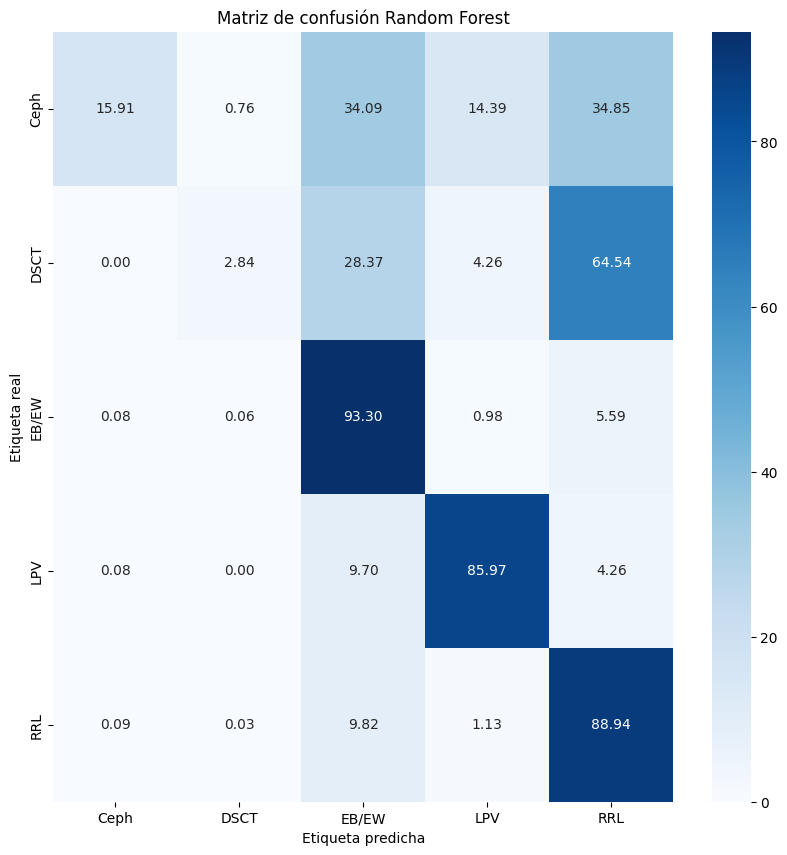

In [30]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión Random Forest')
plt.show()

## Balanced Random Forest

In [ ]:
# balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier with 100 trees
brf = BalancedRandomForestClassifier(n_estimators=100)

# Fit the model to the training data
brf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = brf.score(X_test, y_test)
print('Accuracy:', score)

In [32]:
# Macro metrics
from sklearn.metrics import classification_report

y_pred = brf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Ceph       0.06      0.58      0.10       132
        DSCT       0.04      0.55      0.07       141
       EB/EW       0.87      0.81      0.84      6642
         LPV       0.92      0.83      0.87      2608
         RRL       0.97      0.63      0.77      6925

    accuracy                           0.73     16448
   macro avg       0.57      0.68      0.53     16448
weighted avg       0.91      0.73      0.80     16448



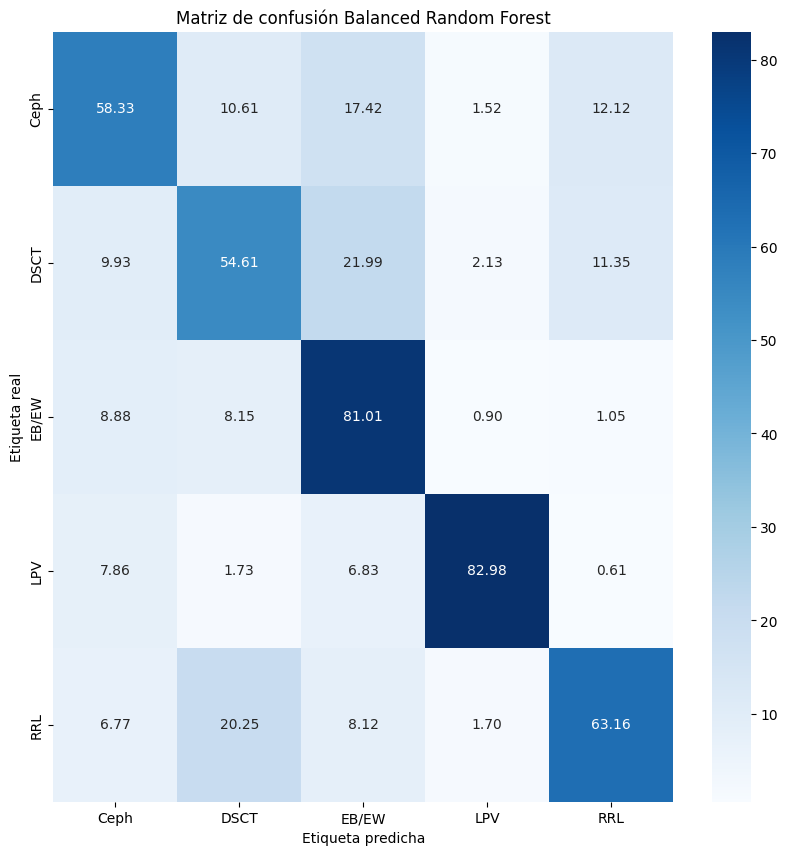

In [27]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = brf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión Balanced Random Forest')
plt.show()
